## Project Food recognition
A.Y. 2020/2021

|  Surname | Name   | Matricola   | Accademic Mail   |
|---|---|---|---|
|Seroyizhko   | Pavlo     |  982598   | pavlo.seroyizhko@studio.unibo.it |
|Wen          | Xiaowei   | 982501  | xiaowei.wen@studio.unibo.it  |

# DATA FORMING

In [22]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow import keras
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
!pip install memory_profiler
import memory_profiler
import threading
import matplotlib.patches as mpatches
%matplotlib inline

In [38]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    

"""
input
    catAlliasList: list - list of dict of format {categoriId: id_of_class}
    key: int - the real category_id
    
output
     int, the associated id to the category_id

"""
def getCatAllias(catAlliasList, key):
    for al in catAlliasList:
        if key in al:
              return al[key]

    return 0 

    
"""
input
    catIDs: list - list of categories ids
output
     list of dict of format {categoriId: id_of_class}
     
     
     The function associate the category id, which might be not numerically ordered. 
     The associated id will be used in forming the output matrix.
     
     For an output matrix y of shape (batch_size, m, n, n_classes), the only non-0 matrix 
     for a certein batch will at the position [batch_number(!!),:,:,id_of_class]
"""
def createCatAllias(catIDs):
    l = []
    i=1
    for id in catIDs:
        l.append({id:i})
        i += 1
    return l


"""
input 
    imageObj: dict - Coco image annotaion
    coco: Coco() - Coco object
    catIDs: list - list of categories ids
    catAllias : list - list of dict of format {categoriId: id_of_class}
    input_image_size: tuple - desired image size (width, height)
    
output
    masks: array - (width, height, n_cat) where n_cat is number of cotegories that are on the photo
    cats: list - list of id assocciated with categories id taken from catAllias
    

"""

def getMasksWithCats(imageObj, coco, catIDs, catAllias, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIDs, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = []
    masks = np.zeros((input_image_size[0], input_image_size[0]))
    for a in range(len(anns)):
        ann = anns[a]
        cat_value = getCatAllias(catAllias, ann['category_id'])
        new_mask = cv2.resize(coco.annToMask(ann)*cat_value, input_image_size)
        masks = np.maximum(new_mask, masks)
        cats.append(cat_value)

    return masks.reshape(input_image_size + (1,)), cats
    
def generateData(images, classes, coco, folder, input_image_size, catAllias, mode='train', batch_size=16):
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    X = []
    y = []
    for imageObj in images:
        X.append(getImage(imageObj, img_folder, input_image_size))
        y.append(getNCLassMask(imageObj, coco, catIds, catAllias, input_image_size))
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y



"""
input

    coco: COCO() - A COCO class with annotions of desired dataset
    images: lsit - list of images obtained from COCO.loadImgs()
    folder: String - root folder with coco images
    input_image_size: tuple - desired image size (width, height)
    catAllias : list - list of dict of format {categoriId: id_of_class}
    mode: String - "train" | "val" | "test"
    batch_size: Int - number of augmented images on output after calling next()
    
output

    python generator function
    

    the function is a python generator function which on calling next() will return
    
    X: array of augmented images of size (batch_size, n, m, 3), where n is width and m is height
    y: array of equally augmented masks of size (batch_size, n, m, n_classes), 
            array will be 0 for all the 4th dimensions that are not the id number of the category
            
    every batch is generated by 1 image on which is going to be applied the keras Image Generator

"""

def cocoDataGenerator(coco, images, folder, input_image_size, catAllias, catIds, mode='train', batch_size=16):
    # coco parameters
    c = 0 # index of desired image that will generate the batch
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    #catIds = coco.getCatIds()
    n_classes = len(catAllias)+1
    lock = threading.Lock()
    
    while(True):
        with lock:
            img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
            mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

            for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
                imageObj = images[i]

                ### Retrieve Image ###
                train_img = getImage(imageObj, img_folder, input_image_size)

                train_mask, m_cats = getMasksWithCats(imageObj, coco, catIds, catAllias, input_image_size)

                # Add to respective batch sized arrays
                img[i-c] = train_img
                mask[i-c] = train_mask
                
             

            c+=batch_size
            if(c + batch_size >= dataset_size):
                c=0
                random.shuffle(images)
                
        yield img, mask



def cocoDataGeneratorWithAug(coco, images, folder, input_image_size, catAllias, catIds, mode='train', batch_size=16):
    
    seed = 32
    augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last') # the arguments used by keras ImageGenerator for images
    
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None) # the arguments used by keras ImageGenerator for mask (same but without brightness)


    # Initialize the mask data generator with modified args
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed) # to avoid randomness between image and masks
    
    # coco parameters
    idx = 0 # index of desired image that will generate the batch
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds()
    n_classes = len(catAllias)+1
    # debug
    start_time = datetime.now()
    start_m = memory_profiler.memory_usage()[0]
    
    # infinite loop is required by keras model
    while(True):       
        
        
        
        #print(f"\n{idx}")
        #print("passed: {} | memory used: {}".format(datetime.now()-start_time, memory_profiler.memory_usage()[0]-start_m))
        start_time = datetime.now()
        start_m = memory_profiler.memory_usage()[0]
        
        imageObj = images[idx]
        img = getImage(imageObj, img_folder, input_image_size) #image_array
        
        #getMasksWithCats return array of masks for each category on the image and a list of squeezed categories 
        im_masks, im_cats = getMasksWithCats(imageObj, coco, catIds, catAllias, input_image_size) 
        n_masks = im_masks.shape[2]
        
        #  output
        X = np.zeros((batch_size, input_image_size[0], input_image_size[1],3)).astype('float')
        y = np.zeros((batch_size, input_image_size[0], input_image_size[1],1)).astype('float')
        
        
        
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        
        # image generator
        g_x = image_gen.flow(img.reshape((1,)+img.shape), 
                             batch_size = batch_size, 
                             seed = seed)
        
        # masks generators
        g_ys = image_gen.flow(im_masks.reshape((1,)+im_masks.shape), 
                             batch_size = batch_size, 
                             seed = seed)
        for batch_num in range(batch_size):
            X[batch_num] = g_x.next()/255.0
            y[batch_num] = g_ys.next()/255.0
            '''
            for i in range(n_masks):
                m = g_ys[i].next()
                m[m>0.5] = im_cats[i]
                 = m#g_ys[i].next()[:, :]

            '''
            
        yield X, y

        if idx > dataset_size:
            idx = 0
            random.shuffle(images)
        else:
            idx += 1

def getClassByAllias(label, cats, catAllias):
    for allias in catAllias:
        for key in allias:
            if allias[key] == label:
                return getClassName(key, cats)

    return "background"


def collectImagesByClasses(coco, filterClasses):
    images = []
    if filterClasses!=None:
        # iterate for each individual class in the list
        for className in filterClasses:
            # get all images containing given class
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)

    # Now, filter out the repeated images    
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])

    dataset_size = len(unique_images)
    
    print("Number of images containing the filter classes:", dataset_size)
    return unique_images

def fisrtNMostFreqCat(coco, n):
    catsIds = coco.getCatIds()
    cats = coco.loadCats(catsIds)
    annIds = coco.getAnnIds()
    anns = coco.loadAnns(annIds)
    cat_freq = []
    while anns:
        cat = anns[0]['category_id']
        f = 0
        for ann in anns:
            if ann['category_id'] == cat:
                f += 1
        
        cat_freq.append({"cat_id":cat, "freq": f})
        
        anns = [x for x in anns if x['category_id'] != cat]
        
    
    cat_freq = sorted(cat_freq, key=lambda k: k["freq"], reverse=True)
    cat_freq = cat_freq[0:n]
    output = []
    for c in cat_freq:
        output.append(getClassName(c["cat_id"], cats))
    return output
def visuallizeMaskWithLabels(mask, cats, catAllias):
    mask = np.rint(mask)
    values, counts = np.unique(mask, return_counts=True)
    values = values[counts>1000]
    im = plt.imshow(mask)
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label=getClassByAllias(values[i], cats, catAllias)) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()

In [3]:
img_dir = "images/"
ann_dir = "annotations/"
dataType = "train"

In [4]:
ann_file_train = ann_dir+"train.json"
ann_file_val = ann_dir+"val.json"
coco_train=COCO(ann_file_train)
coco_val=COCO(ann_file_val)

loading annotations into memory...
Done (t=1.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [5]:
filterClasses = fisrtNMostFreqCat(coco_train, 18)
filterClasses.remove('coffee-with-caffeine')
filterClasses.remove('espresso-with-caffeine')
catIDs = np.sort(coco_train.getCatIds(catNms=filterClasses))
cats = coco_train.loadCats(catIDs)
images_train = collectImagesByClasses(coco_train, filterClasses)
images_val = collectImagesByClasses(coco_val, filterClasses)
img_height = 480
img_width = 480
imgs_size = (img_width, img_height)
cat_allias = createCatAllias(catIDs)

n_train_imgs = len(images_train)
n_val_imgs = len(images_val)
n_classes = len(cats) + 1
batch_size = 3

Number of images containing the filter classes: 8906
Number of images containing the filter classes: 458


In [16]:
getClassByAllias(0, cats, cat_allias)

'backgound'

In [19]:
dg_train = cocoDataGenerator(coco_train, images_train, os.getcwd(), imgs_size, cat_allias,catIDs, batch_size=batch_size)
dg_val = cocoDataGenerator(coco_val, images_val,  os.getcwd(), imgs_size, cat_allias, catIDs, mode = "val", batch_size=batch_size)

In [29]:
x, y = next(dg_train)

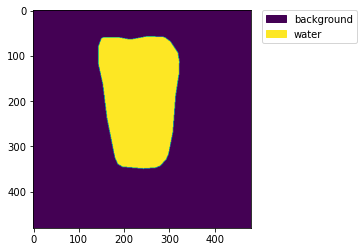

In [39]:
visuallizeMaskWithLabels(y[0,:,:,0], cats, cat_allias)

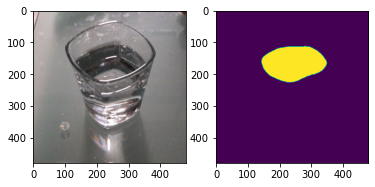

In [20]:
plt.subplot(121)
plt.imshow(x[2])
plt.subplot(122)
plt.imshow(y[2,:,:,0])

In [ ]:
import tensorflow as tf
print(f"sample shape {tf.shape(sample_image)}")
print(f"sample_mask shape {tf.shape(sample_mask)}")

sample_image = tf.reshape(sample_image, [480,480,3])

sample_mask = tf.reshape(sample_mask, [480,480,1])

print(f"sample shape {tf.shape(sample_image)}")
print(f"sample_mask shape{tf.shape(sample_mask)}")

sample shape [  1 480 480   3]
sample_mask shape [  1 480 480   1]
sample shape [480 480   3]
sample_mask shape[480 480   1]


# CNN

In [18]:
from TiramisuNet import TiramisuNet


In [19]:
# metteremo questo messaggio per fare piu volte lo stesso training
# model = keras.models.load_model('food_recognition')

model = None 
if model is None:
  model = TiramisuNet(
      input_shape=imgs_size + (3,)
      , n_classes=n_classes
  )

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(x = dg_train,
                validation_data = dg_val,
                steps_per_epoch = 5,
                validation_steps = 5,
                epochs = 1,
                verbose = True)

5/5 [==============================] - 791s 154s/step - loss: 68.1331 - accuracy: 0.0810 - val_loss: 9227.5635 - val_accuracy: 0.0000e+00


In [ ]:
# model.save("food_recognition")